<a href="https://colab.research.google.com/github/sokrypton/seqmodels/blob/master/seqmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from scipy.spatial.distance import squareform

## inv_cov

In [0]:
def INV_COV(X,W,pcc=False,do_mean=True):
  
  def tf_cov(x,w=None,do_mean=True):
    '''compute weighted covariance matrix'''
    if w is None:
      num_points = tf.cast(tf.shape(x)[0],tf.float32) - 1.0
      if do_mean:
        x_mean = tf.reduce_mean(x, axis=0, keep_dims=True)
        x = (x - x_mean)
    else:
      num_points = tf.reduce_sum(w) - tf.sqrt(tf.reduce_mean(w))
      if do_mean:
        x_mean = tf.reduce_sum(x * w[:,None], axis=0, keepdims=True) / num_points
        x = (x - x_mean) * tf.sqrt(w[:,None])
      else:
        x = x * tf.sqrt(w[:,None])
    return tf.matmul(tf.transpose(x),x)/num_points

  tf.reset_default_graph()
  
  # input msa
  x = tf.placeholder(tf.uint8,shape=(None,None),name="x")
  # input weight per sequence
  x_weights = tf.placeholder(tf.float32,shape=(None,),name="x_weights") 
  
  x_shape = tf.shape(x)
  x_nr = x_shape[0] # num rows
  x_nc = x_shape[1] # num cols

  cat = 21
  x_msa = tf.one_hot(x,cat) # one-hot encode msa
  x_feat = tf.reshape(x_msa,(x_nr, x_nc * cat))

  # compute covariance
  x_c = tf_cov(x_feat,x_weights,do_mean=do_mean)

  # add reg
  x_reg_b = 4.5
  x_reg_alpha = x_reg_b/tf.sqrt(tf.reduce_sum(x_weights))
  x_c = x_c + x_reg_alpha * tf.eye(x_nc * cat)
  
  # compute inverse
  x_c_inv = tf.linalg.inv(x_c)
  
  if pcc:
    # partial correlation coefficient
    x_c_inv_diag = tf.linalg.diag_part(x_c_inv)
    x_c_inv = x_c_inv / tf.sqrt(x_c_inv_diag[None,:] * x_c_inv_diag[:,None])
    
  # get w matrix
  x_w = tf.reshape(x_c_inv,shape=(x_nc,cat,x_nc,cat))
  x_w = x_w[:,:-1,:,:-1]
  x_wi = tf.sqrt(tf.reduce_sum(tf.square(x_w),axis=(1,3)))
  x_wi = x_wi * (1.0 - tf.eye(x_nc))
    
  # do apc
  x_ap_sum = tf.reduce_sum(x_wi,axis=0)
  x_ap = x_ap_sum[None,:] * x_ap_sum[:,None] / tf.reduce_sum(x_ap_sum)
  x_wip = (x_wi - x_ap) 
  x_wip = x_wip * (1.0 - tf.eye(x_nc))
  
  # start session, return apc corrected matrix
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    return sess.run(x_wip,{x:X,x_weights:W})

## functions for MSE/CCE

In [0]:
def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
  '''adam optimizer'''
  
  if var_list is None: var_list = tf.trainable_variables() 
  gradients = tf.gradients(loss,var_list)
  if b_fix: t = tf.Variable(0.0,"t")
  opt = []
  for n,(x,g) in enumerate(zip(var_list,gradients)):
    if g is not None:
      ini = dict(initializer=tf.zeros_initializer,trainable=False)
      mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
      vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)
      
      mt_tmp = b1*mt+(1-b1)*g
      vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
      lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

      if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

      opt.append(x.assign_add(-lr_tmp * mt_tmp))
      opt.append(vt.assign(vt_tmp))
      opt.append(mt.assign(mt_tmp))
        
  if b_fix: opt.append(t.assign_add(1.0))
  return(tf.group(opt))

def sym_w(w,w_zero=True):
  '''symmetrize input matrix of shape (x,y,x,y)'''
  x = w.shape[0]
  if w_zero:
    w = w * np.reshape(1-np.eye(x),(x,1,x,1))
  w = w + tf.transpose(w,[2,3,0,1])
  return w

## MSE

In [0]:
def MSE(X,W,lam_w=4.5,opt_iter=200):  
  
  def L2(x, axis=None):
    return tf.reduce_sum(tf.square(x),axis=axis)
  
  tf.reset_default_graph()
  
  ln = X.shape[1]
  fs = ln * 21
  
  x = tf.constant(X,tf.uint8)
  x = tf.one_hot(x,21)  
  x_weights = tf.constant(W,tf.float32)
  
  x_true = tf.reshape(x,(-1,fs))  
  x_mean = tf.reduce_mean(x_true, axis=0, keepdims=True)
  
  w = tf.get_variable("w",shape=(fs,fs),initializer=tf.zeros_initializer)
  w = w + tf.transpose(w)
  
  x_pred = tf.tensordot(x_true - x_mean, w, 1) + x_mean
    
  loss = tf.reduce_sum(L2(x_true-x_pred,-1) * x_weights) / tf.reduce_sum(x_weights)
  loss = loss - 2.0 * tf.trace(w)

  x_w = tf.reshape(w,(ln,21,ln,21))
  
  if lam_w > 0:
    loss_reg = (lam_w/tf.sqrt(tf.reduce_sum(x_weights))) * L2(w)
    loss = loss + loss_reg    
  
  x_wi = tf.sqrt(tf.reduce_sum(tf.square(x_w[:,:-1,:,:-1]), axis=(1,3)))
  x_wi = x_wi * (1-tf.eye(ln))
  
  x_ap_sum = tf.reduce_sum(x_wi,axis=0)
  x_ap = x_ap_sum[None,:] * x_ap_sum[:,None] / tf.reduce_sum(x_ap_sum)
  x_wip = (x_wi - x_ap)
  x_wip = x_wip * (1-tf.eye(ln))
  
  opt = opt_adam(loss,"opt",lr=1.0)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(opt_iter):
      sess.run(opt)
      #if ((i+1) % 10) == 0:
      #  print((i+1),sess.run(loss))
    return sess.run(x_wip)

## CCE

In [0]:
def CCE(msa,
        msa_weights=None,
        opt_rate=0.5,
        opt_iter=200,
        use_bias=True,
        lam_w=0.01,
        lam_b=0.01,
        ignore_gap=False):

  # collecting some information about input msa
  nrow = msa.shape[0] # number of sequences
  ncol = msa.shape[1] # length of sequence
  if ignore_gap:
    ncat = 20
  else:
    ncat = 21
  
  if msa_weights is None:
    msa_weights = np.ones(nrow)
  
  # kill any existing tensorflow graph
  tf.reset_default_graph()

  # setting up weights
  if use_bias:
    b = tf.get_variable("b", [ncol,ncat],
                        initializer=tf.initializers.zeros)
    
  w = tf.get_variable("w", [ncol,ncat,ncol,ncat],
                      initializer=tf.initializers.zeros)
  # symmetrize w
  w = sym_w(w)
  
  # input
  X = tf.constant(msa,tf.uint8,name="x")
  MSA = tf.one_hot(X,21)
  if ignore_gap:
    non_gap = tf.abs(1.0 - MSA[...,-1])
    MSA = MSA[...,:-1]
  
    
  MSA_weights = tf.constant(msa_weights,tf.float32,name="msa_weights")
  NEFF = tf.reduce_sum(MSA_weights)

  # dense layer + softmax activation
  a = tf.tensordot(MSA,w,2)

  if use_bias:
    MSA_logit = a + b
  else:
    MSA_logit = a
    
  MSA_pred = tf.nn.softmax(MSA_logit, -1)

  # loss = categorical crossentropy (aka pseudo-likelihood)
  loss = tf.keras.losses.categorical_crossentropy(MSA,MSA_pred)
  if ignore_gap:
    loss = loss * non_gap
    
  loss = tf.reduce_sum(loss, axis=-1)
  loss = tf.reduce_sum(loss * MSA_weights)/NEFF

  # add L2 regularization
  reg_w = lam_w * tf.reduce_sum(tf.square(w)) * 0.5 * (ncol-1) * 20.0 
  if use_bias:
    reg_b = lam_b * tf.reduce_sum(tf.square(b))
    loss = loss + (reg_b + reg_w)/NEFF
  else:
    loss = loss + (reg_w)/NEFF

  opt = opt_adam(loss,"adam", lr=opt_rate)
  x_w = w
  
  # l2norm
  if ignore_gap is False:
    x_w = x_w[:,:-1,:,:-1]
  
  x_wi = tf.sqrt(tf.reduce_sum(tf.square(x_w), axis=(1,3))) * (1-tf.eye(ncol))
  
  # do apc
  x_ap_sum = tf.reduce_sum(x_wi,axis=0)
  x_ap = x_ap_sum[None,:] * x_ap_sum[:,None] / tf.reduce_sum(x_ap_sum)
  x_wip = (x_wi - x_ap) * (1-tf.eye(ncol))
  
  with tf.Session() as sess:
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    if use_bias:
      msa_cat = np.eye(21)[msa]
      if ignore_gap:
        msa_cat = msa_cat[...,:-1]
      pseudo_count = 0.01 * np.log(np.sum(msa_weights))
      b_ini = np.log(np.sum(msa_cat.T * msa_weights,-1).T + pseudo_count)
      b_ini = b_ini - np.mean(b_ini,-1,keepdims=True)
      sess.run(b.assign(b_ini))
    
    for k in range(opt_iter):
      sess.run(opt)
      #if (k+1) % int(opt_iter/10) == 0:
      #  print((k+1),sess.run(loss))      
    return sess.run(x_wip)

## DATASET

In [0]:
import pickle

In [0]:
%%bash 
wget -nc -q https://github.com/sokrypton/seqmodels/raw/master/data.pickle.gz
gunzip data.pickle.gz

In [0]:
data = pickle.load(open("data.pickle","rb"))

In [0]:
def get_acc(pred,true,sub_ln):
  pred_true = np.stack((pred,true),-1)
  pred_true = pred_true[pred_true[:,0].argsort()[::-1]]
  acc = []
  for n in range(0,10):
    N = int(sub_ln * (n+1)/10)
    acc.append(np.mean(pred_true[:N,1]))
  return np.mean(acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
4ACIA 0.34945929711221285 0.3780034586468807


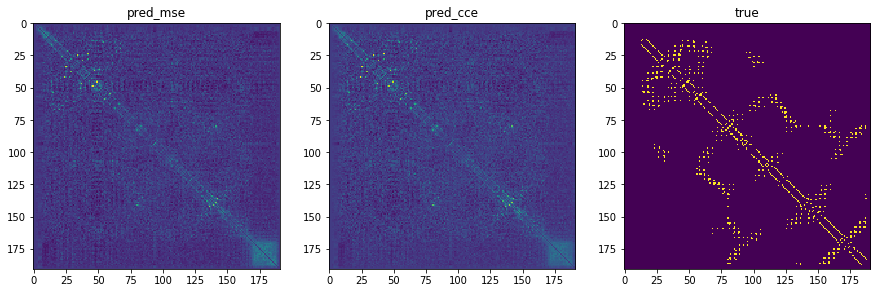

3A1SA 0.5823438048059085 0.6905096518827087


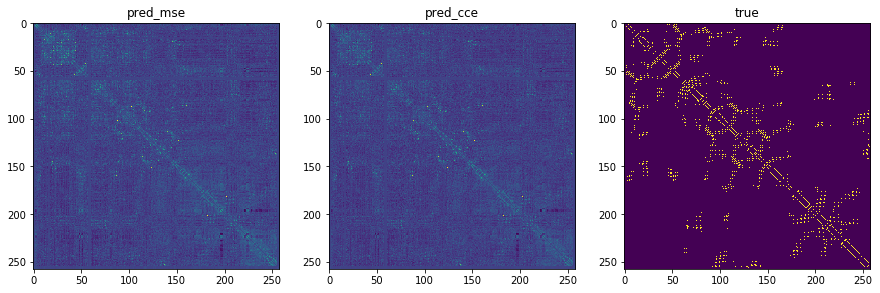

4C76A 0.7008446623799367 0.7499830834488392


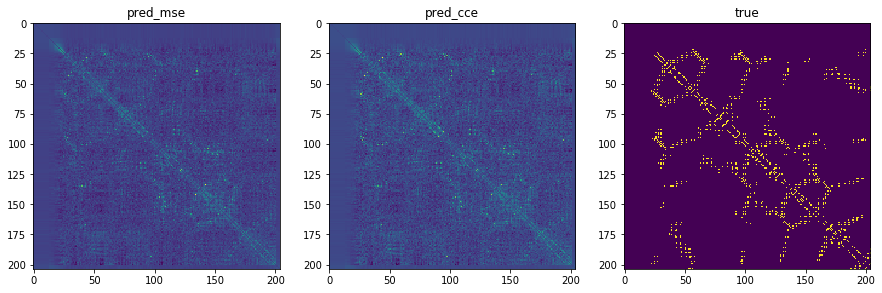

2G1UA 0.6949902808938543 0.7308894015247471


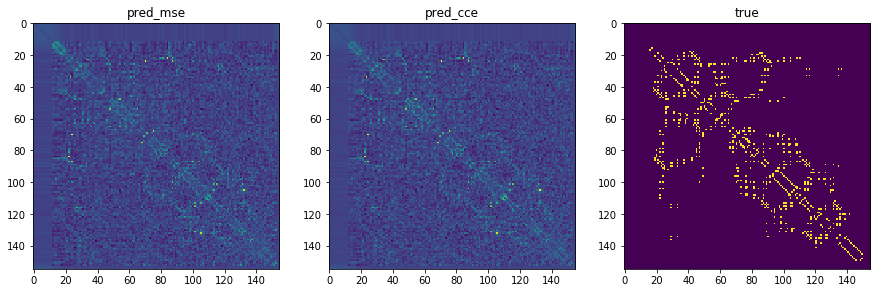

3AJDA 0.7683758556752521 0.8008501673297074


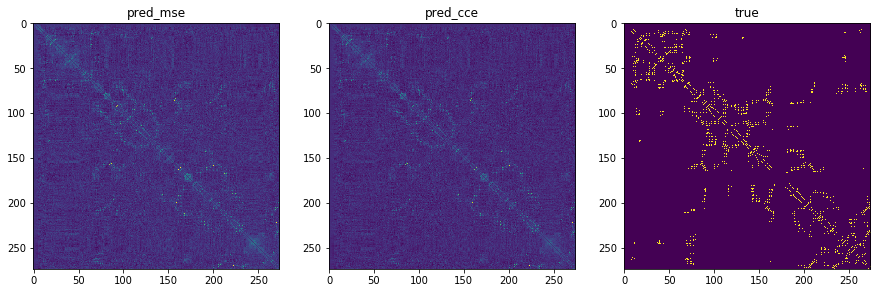

In [11]:
stop = 3
for n,a in enumerate(data):
  sub_ln = np.sum((np.sum(a["x_mask"],axis=-1) > 0))
  
  idx = np.triu_indices_from(a["x_true"],k=6)
  mask = np.where(a["x_mask"][idx] > 0)
  true = a["x_true"]

  #pred_ic = INV_COV(a["x"],a["x_w"])
  pred_mse = MSE(a["x"],a["x_w"])
  pred_cce = CCE(a["x"],a["x_w"])

  #acc_ic = get_acc(pred_ic[idx][mask],true[idx][mask],sub_ln)
  acc_mse = get_acc(pred_mse[idx][mask],true[idx][mask],sub_ln)
  acc_cce = get_acc(pred_cce[idx][mask],true[idx][mask],sub_ln)
  
  print(a["x_id"],acc_ic,acc_mse,acc_cce)
  
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1); plt.title("pred_mse"); plt.imshow(pred_mse)
  plt.subplot(1,3,2); plt.title("pred_cce"); plt.imshow(pred_cce)
  plt.subplot(1,3,3); plt.title("true"); plt.imshow(true)
  plt.show()
  
  if n > stop: break 